In [254]:
%matplotlib inline
from __future__ import print_function
import openpiv.process
import openpiv.filters
import openpiv.scaling
import openpiv.validation
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import animation, rc
from IPython.display import HTML
import numpy as np
import math
from PIL import Image
import tiffile as tiffile
import cv2
import time

def display(array, show_colorbar=False, title=None):
    #fig = plt.figure()
    fig = plt.imshow(array)
    if show_colorbar:
        plt.colorbar(fig)
    if title != None:
        plt.title(str(title))
    plt.show()
    
def display_2col(arr1, arr2, arr1_title="Ass", arr2_title="Hat"):
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(arr1)
    axarr[0].set_title(arr1_title)
    axarr[1].imshow(arr2)
    axarr[1].set_title(arr2_title)
    plt.show()
    
    
    
indir = "/Users/jens_e/Python_laboratory/Vector_visualizer/test"
outdir = "/Users/jens_e/Python_laboratory/Vector_visualizer/test/out/"

testfile = "/Users/jens_e/Python_laboratory/Vector_visualizer/test/sub.tif"
testfile2 = "/Users/jens_e/Python_laboratory/Vector_visualizer/test/med_raw.tif"
testfile_median = "/Users/jens_e/Python_laboratory/Vector_visualizer/test/sub_median_3_frames.tif"
testfile_gliding_median = "/Users/jens_e/Python_laboratory/Vector_visualizer/test/sub_gliding_median_3_frames.tif"

# PIV analysis

This is the analysis of PIV data on collectively migrating cells with H2B-mCherry. I hope to generate an number for the directional persistence and the migration speed in each time frame.

Let's first open a small testfile, in this case a subframe from a H2B-histone tagged HaCaT cell line migrating

In [74]:
with tiffile.TiffFile(testfile) as tif:
    arr = tif.asarray()
    arr = arr.astype(np.int32)

print(arr.shape)

(300, 263, 263)


The array is 263x263 and has 300 frames in one color channel. Let's look at the 60th and 61st frames:

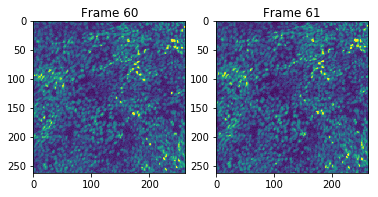

In [74]:
display_2col(arr[59], arr[60], "Frame 60", "Frame 61")


Now, lets have a look at it as an animation, as done [here](http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/).

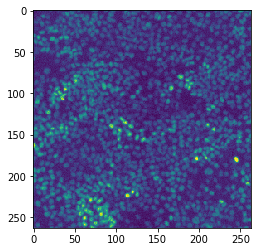

In [6]:
fig = plt.figure();

def get_frame(array, frame_index):
    return array[frame_index]

i = 0

im = plt.imshow(get_frame(arr, i), animated=True);


def updatefig(*args):
    global i
    global arr
    i += 1
    if i > arr.shape[0]:
        i = 0
    
    im.set_array(get_frame(arr, i));
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=100, blit=True);


In [76]:
HTML(ani.to_html5_video())

Cool, let's make a function that shows an animation for future use.

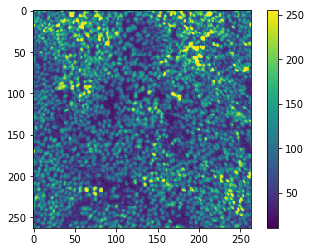

In [7]:
def show_animation(array_to_animate, update_interval=50, limits=None):
    
    #array_to_animate = array_to_animate
    fig = plt.figure()
    i = [0] #internal function calls need to work on mutables
    im = plt.imshow(array_to_animate[i[0]], animated=True)
    plt.colorbar(im)
    
    if limits != None:
        im.set_clim(limits)

    def updatefig(*args):
                
        if i[0] > array_to_animate.shape[0]-1:
            i[0] = 0

        im.set_array(array_to_animate[i[0]])
        
        i[0] = i[0]+1
        
        return im,
    


    return HTML(animation.FuncAnimation(fig, updatefig, interval=update_interval, blit=True).to_html5_video())

show_animation(arr)

# PIV

Let's perform a simple PIV analysis on frames 60 & 61. But first we need to set up a helper function that does the PIV calculations, given two frames. In this case it will return an array representing the length of the velocity vectors.

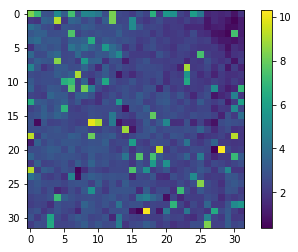

In [8]:
def speed_frame_processor(frame_a, frame_b, window_size = 8, overlap = 0, search_area = 10,
                          sig2noise_method="peak2peak", threshold=None):
    
    if (threshold != None) and (sig2noise_method == None):
        raise Exception("Thresholding requires a sig2noise value to work!")
    
    
    if (sig2noise_method == None):

        u, v = openpiv.process.extended_search_area_piv(frame_a, frame_b, window_size=window_size,
                                                       overlap=overlap,
                                                       dt=1, search_area_size=search_area,
                                                       sig2noise_method=sig2noise_method)
        return np.sqrt((u ** 2 + v ** 2))
    
    
    u, v, sig2noise = openpiv.process.extended_search_area_piv(frame_a, frame_b, window_size=window_size,
                                                               overlap=overlap,
                                                               dt=1, search_area_size=search_area,
                                                               sig2noise_method=sig2noise_method)

    speeds = np.sqrt((u ** 2 + v ** 2))


    if (threshold != None):
        mask = sig2noise >= threshold

        speeds = np.ma.masked_array(speeds, mask)



    return speeds

#PIV parameters
speed_piv_params = dict(window_size = 8,
                      overlap = 0,
                  search_area = 12,
             sig2noise_method = None,
                    threshold = None)


display(speed_frame_processor(arr[59], arr[60], **speed_piv_params), True) #Show speeds with colorbar




        


Looks good, but it lacks a proper scale and labels, but we are improving. Let's try and make an animation of the speeds as they evolve during the timelapse. To acheive this we will need to create a funtion that processes the entire multidimensional array and displays it as an animation.

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars


Test array took 184.1 s to process


/usr/local/lib/python2.7/site-packages/matplotlib/image.py:371: RuntimeWarning: invalid value encountered in less
  rgba[..., 1] = A < 0  # under data
/usr/local/lib/python2.7/site-packages/matplotlib/image.py:372: RuntimeWarning: invalid value encountered in greater
  rgba[..., 2] = A > 1  # over data


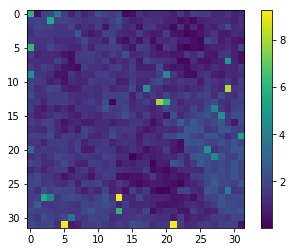

In [9]:
def speed_array_processor(arr, speed_piv_params, stopFrame, startFrame=0, frameSamplingInterval=1):
    """
    Returns a list of the speeds (velocity vector magnitudes in each frame of arr) in the unit pixels/frame.
    """
    assert (startFrame < stopFrame) and (stopFrame <= arr.shape[0])
    
    n_frames = 1 + (stopFrame-startFrame-1) // frameSamplingInterval
    
    x, y = openpiv.process.get_coordinates(image_size=arr[0].shape,
                                           window_size=speed_piv_params["window_size"],
                                           overlap=speed_piv_params["overlap"])

    out = np.zeros((n_frames, x.shape[0], x.shape[1]))


    for frame in range(startFrame, stopFrame, frameSamplingInterval):
        
        if frame >= (stopFrame-1):
            break

        frame_a = arr[frame]
        frame_b = arr[frame+1]
        
        out[frame] = speed_frame_processor(frame_a, frame_b, **speed_piv_params)
        
    
    return out

        
t0 = time.time()       
tst = speed_array_processor(arr, speed_piv_params, arr.shape[0])
print("Test array took %.1f s to process" % (time.time()-t0))
show_animation(tst)



Seems to work ok, but there is a lot of noise and stuff in the speeds. Let's now just plot the frame-by-frame mean speeds.

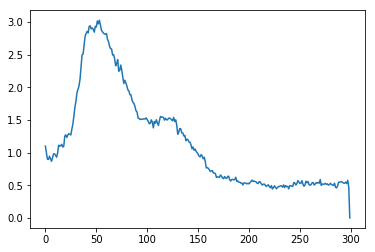

In [7]:
frame_mean_speeds = np.nanmean(tst, axis=(1,2))
plt.plot(frame_mean_speeds)
plt.show()

Alright, alrigh, alright, looks nice. Let's just have a quick look at the PIV implementation from the openCV library. It is based on Gunnar Farnebäck's paper ["Two-Frame Motion Estimation Based on Polynomial Expansion"][1].

[1]: Farnebäck G. (2003) Two-Frame Motion Estimation Based on Polynomial Expansion. In: Bigun J., Gustavsson T. (eds) Image Analysis. SCIA 2003. Lecture Notes in Computer Science, vol 2749. Springer, Berlin, Heidelberg

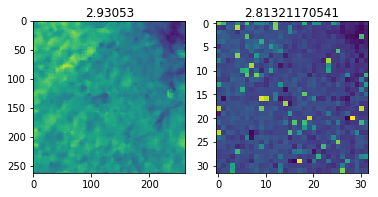

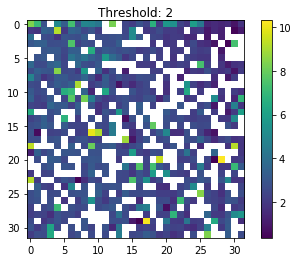

Mean thresholded value: 2.94


In [8]:
def cv2_speed_frame_processor(frame_a, frame_b, **kwargs):
    
    out = cv2.calcOpticalFlowFarneback(frame_a, frame_b, **kwargs)

    
    u, v = out[...,0], out[...,1]
    
    speeds = np.sqrt((u ** 2 + v ** 2))

    return speeds

cv2_params = dict(flow = None,
                  pyr_scale = 0.5,
                  levels = 1,
                  winsize =9,
                  iterations = 1,
                  poly_n = 7,
                  poly_sigma = 1.5,
                  flags = 0)

piv_params = dict(window_size = 8,
                overlap = 0,
                search_area = 12,
                threshold = None)

cv2_img = cv2_speed_frame_processor(arr[59], arr[60], **cv2_params)
open_piv = speed_frame_processor(arr[59], arr[60], **piv_params)

display_2col(cv2_img, open_piv,
            arr1_title=str(np.mean(cv2_img, axis=(0,1))),
            arr2_title=str(np.mean(open_piv, axis=(0,1)))
            )

piv_params = dict(window_size = 8,
                overlap = 0,
                search_area = 12,
                threshold = 2)

open_piv_thesholded = speed_frame_processor(arr[59], arr[60], **piv_params)
display(open_piv_thesholded, title="Threshold: "+str(piv_params['threshold']), show_colorbar=True)
print("Mean thresholded value: %.2f" % (np.mean(open_piv_thesholded)))

In [9]:
def cv2_array_processor(arr, cv2_params, stopFrame, startFrame=0, frameSamplingInterval=1):

    assert stopFrame <= arr.shape[0]
    
    if cv2_params == None:
    #Defalt parameters
        cv2_params = dict(flow = None,
                          pyr_scale = 0.5,
                          levels = 1,
                          winsize =9,
                          iterations = 1,
                          poly_n = 7,
                          poly_sigma = 1.5,
                          flags = 0)

    out_u, out_v = [], []
    for frame in range(startFrame, stopFrame, frameSamplingInterval):
        #print("Starting frame:", frame)
        if frame >= (stopFrame-1):
            break

        frame_a = arr[frame]
        frame_b = arr[frame+1]
        
        out = cv2.calcOpticalFlowFarneback(frame_a, frame_b, **cv2_params)
        out_u.append(out[...,0])
        out_v.append(out[...,1])

    return np.array(out_u), np.array(out_v)

Test array took 5.6 s to process


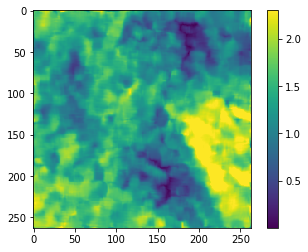

In [10]:
def cv2_speed_array_processor(arr, cv2_params, stopFrame, startFrame=0, frameSamplingInterval=1):

    assert stopFrame <= arr.shape[0]
    if cv2_params == None:
    #Defalt parameters
        cv2_params = dict(flow = None,
                          pyr_scale = 0.5,
                          levels = 1,
                          winsize =9,
                          iterations = 1,
                          poly_n = 7,
                          poly_sigma = 1.5,
                          flags = 0)

    out = []

    for frame in range(startFrame, stopFrame, frameSamplingInterval):
        #print("Starting frame:", frame)
        if frame >= (stopFrame-1):
            break

        frame_a = arr[frame]
        frame_b = arr[frame+1]
        
        out.append(cv2_speed_frame_processor(frame_a, frame_b, **cv2_params))
        
    
    return np.array(out)

cv2_params = dict(flow = None,
             pyr_scale = 0.5,
                levels = 1,
               winsize =9,
            iterations = 1,
                poly_n = 7,
            poly_sigma = 1.5,
                 flags = 0)
    
    
t0 = time.time()       
cv2_tst = cv2_speed_array_processor(arr, cv2_params, stopFrame=arr.shape[0])
print("Test array took %.1f s to process" % (time.time()-t0))
show_animation(cv2_tst)


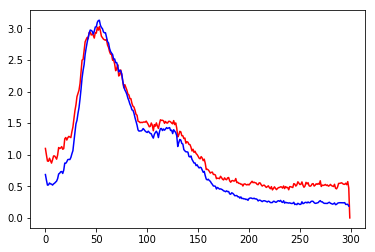

In [11]:
frame_mean_speeds = np.nanmean(tst, axis=(1,2))
cv2_frame_mean_speeds = np.nanmean(cv2_tst, axis=(1,2))

plt.plot(frame_mean_speeds, 'r', cv2_frame_mean_speeds, 'b')

plt.show()

Almost identical results with a 50-fold improvement in computation time! Let's see if we can improve the performance of the openPIV algoritm by trying differently sized interrogation windows. We can also cut the analysis at frame 200.

In [405]:
speed_piv_params1 = dict(window_size = 9,
                             overlap = 0,
                         search_area = 13,
                    sig2noise_method = None,
                           threshold = None)

speed_piv_params2 = dict(window_size = 16,
                             overlap = 8,
                         search_area = 20,
                    sig2noise_method = None,
                           threshold = None)

speed_piv_params3 = dict(window_size = 32,
                             overlap = 16,
                         search_area = 36,
                    sig2noise_method = None,
                           threshold = None)

speed_piv_params4 = dict(window_size = 32,
                             overlap = 0,
                         search_area = 36,
                    sig2noise_method = None,
                           threshold = None)


In [391]:
t0 = time.time()

speeds_1 = speed_array_processor(arr=arr, speed_piv_params=speed_piv_params1, stopFrame=200)
t1 = time.time()-t0

speeds_2 = speed_array_processor(arr=arr, speed_piv_params=speed_piv_params2, stopFrame=200)
t2 = time.time()-(t1+t0)

speeds_3 = speed_array_processor(arr=arr, speed_piv_params=speed_piv_params3, stopFrame=200)
t3 = time.time()-(t2+t0)

speeds_4 = speed_array_processor(arr=arr, speed_piv_params=speed_piv_params4, stopFrame=200)
t4 = time.time()-(t3+t0)

print("Speed params #1 %.1f s, #2 %.1f s, #3 %.1f s, 4# %.1f s" % (t1, t2, t3, t4))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars


Speed params #1 103.6 s, #2 138.4 s, #3 150.1 s, 4# 151.3 s


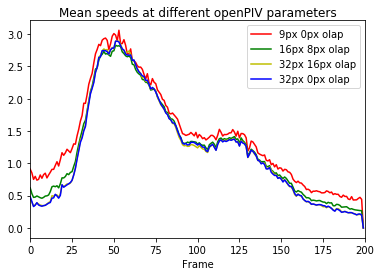

In [433]:
mean_speeds1 = np.nanmean(speeds_1, axis=(1,2))
mean_speeds2 = np.nanmean(speeds_2, axis=(1,2))
mean_speeds3 = np.nanmean(speeds_3, axis=(1,2))
mean_speeds4 = np.nanmean(speeds_4, axis=(1,2))

#plt.plot(mean_speed, 'b', label = "8px 0px olap ")
plt.plot(mean_speeds1, 'r', label="9px 0px olap")
plt.plot(mean_speeds2, 'g', label="16px 8px olap")
plt.plot(mean_speeds3, 'y', label="32px 16px olap")
plt.plot(mean_speeds4, 'b', label="32px 0px olap")

plt.xlabel("Frame")
plt.xlim((0,200))
plt.title("Mean speeds at different openPIV parameters")
plt.legend()
plt.show()

In [421]:
a = arr[59]
b = arr[60]

%timeit speed_frame_processor(a, b, **speed_piv_params)
%timeit speed_frame_processor(a, b, **speed_piv_params1)
%timeit speed_frame_processor(a, b, **speed_piv_params2)
%timeit speed_frame_processor(a, b, **speed_piv_params3)
%timeit speed_frame_processor(a, b, **speed_piv_params4)

1 loop, best of 3: 670 ms per loop
1 loop, best of 3: 567 ms per loop
1 loop, best of 3: 556 ms per loop
10 loops, best of 3: 170 ms per loop
10 loops, best of 3: 47.6 ms per loop


32 pixel windows with zero overlap seems like,the fastest way to capture the velocity fields. in the test image the pixel size is 2.62 µm/pixel, so each window represents ≈ 84x84 µm. Let's finally have a look at how search area size affects analysis time and reults.


In [420]:
speed_piv_params0 = dict(window_size = 32,
                             overlap = 0,
                    sig2noise_method = None,
                           threshold = None)

%timeit speed_frame_processor(a, b, search_area=32, **speed_piv_params0)
%timeit speed_frame_processor(a, b, search_area=33, **speed_piv_params0)
%timeit speed_frame_processor(a, b, search_area=34, **speed_piv_params0)
%timeit speed_frame_processor(a, b, search_area=35, **speed_piv_params0)
%timeit speed_frame_processor(a, b, search_area=40, **speed_piv_params0)

print(np.nanmean(speed_frame_processor(a, b, search_area=32, **speed_piv_params0)))
print(np.nanmean(speed_frame_processor(a, b, search_area=33, **speed_piv_params0)))
print(np.nanmean(speed_frame_processor(a, b, search_area=34, **speed_piv_params0)))
print(np.nanmean(speed_frame_processor(a, b, search_area=35, **speed_piv_params0)))
print(np.nanmean(speed_frame_processor(a, b, search_area=40, **speed_piv_params0)))
print(np.nanmean(speed_frame_processor(a, b, search_area=64, **speed_piv_params0)))



10 loops, best of 3: 43.1 ms per loop
10 loops, best of 3: 52.4 ms per loop
10 loops, best of 3: 56.5 ms per loop
10 loops, best of 3: 52.6 ms per loop
10 loops, best of 3: 50.6 ms per loop
2.58464087578
2.59099818482
2.60379964533
2.64912978822
2.84177095951
3.42467400093


Speed of computation seems not too affected, the mean speed is however. Let's look at a more ralisticly sized array, a 2542x2542 pixel (6663^2 µm) mosaic from where the first subframe is taken.

In [159]:
with tiffile.TiffFile(testfile2) as tif:
    arr2 = tif.asarray()
    arr2 = arr2.astype(np.int32)

print(arr2.shape)

(12, 2542, 2542)


In [ ]:
window_sizes = [8, 12, 16, 32, 64]
search_area_explansion = [0, 2, 4, 8]
times, mean_speeds=[], []
for ws in window_sizes:
    for sa in search_area_explansion:
        search_area = ws+sa
        speed_piv_params = dict(window_size = ws,
                                    overlap = 0,
                                search_area = search_area,
                           sig2noise_method = None,
                                  threshold = None)
        t0 = time.time()
        tst2 = speed_array_processor(arr2, speed_piv_params, stopFrame=arr2.shape[0])
        mean_speed = np.nanmean(tst2)
        pr_time = time.time()-t0
        times.append(pr_time)
        mean_speeds.append(mean_speed)
        print("Full-size array processed in %.1f s with %i px window, %i px search area, mean speed %.2f" % 
              (pr_time, ws, search_area, mean_speed))


The full-size test array took 20.1 s to process with openCV


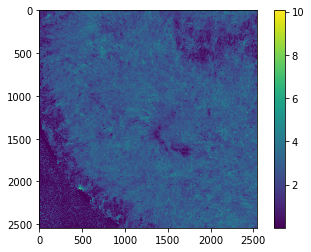

In [397]:
    cv2_params = dict(flow = None,
                      pyr_scale = 0.5,
                      levels = 3,
                      winsize =9,
                      iterations = 3,
                      poly_n = 7,
                      poly_sigma = 1.5,
                      flags = 0)

t0 = time.time()       
cv2_tst2 = cv2_speed_array_processor(arr2, stopFrame=arr2.shape[0])
print("The full-size test array took %.1f s to process with openCV" % (time.time()-t0))
show_animation(cv2_tst2)


In [15]:
frame_mean_speeds = np.nanmean(tst2, axis=(1,2))
cv2_frame_mean_speeds = np.nanmean(cv2_tst2, axis=(1,2))

plt.plot(frame_mean_speeds, 'b', label="openPIV 32px 0ol")
plt.plot(cv2_frame_mean_speeds, 'r', label="openCV")
plt.legend()
plt.show()

NameError: name 'tst2' is not defined

Let's implement the aligmnent index from the paper. First we make a function that computes an array of aligment indexes from two u,v component arrays. The aligment index is defined as the dot product of a velocity vector (vextor_x) and the average velocity vector (vector_0) for the frame, divided by the product of their magnitudes. Like so: alignment_index = (vector_x dot vector_0)/(|vector_x||vector_0|).

In [16]:
def alignment_index(u,v):
    """
    Returns an array of the same shape as u and v with the aligmnent index, as in Malinverno et. al 2017
    """
    
    assert (u.shape == v.shape) and (len(u.shape) == 2) #Only single frames are processed
       
    vector_0 = np.array((np.mean(u), np.mean(v)))
    v0_magnitude = np.linalg.norm(vector_0)

    vector_magnitudes = np.sqrt((np.square(u) + np.square(v)))
    magnitude_products = vector_magnitudes * v0_magnitude
    dot_products = u*vector_0[0] + v*vector_0[1]

    ai = np.divide(dot_products, magnitude_products)
    
    return ai, vector_magnitudes





In [18]:
cv2_params = dict(flow = None,
                pyr_scale = 0.5,
                levels = 3,
                winsize =9,
                iterations = 3,
                poly_n = 7,
                poly_sigma = 1.5,
                flags = 0)

flow = cv2.calcOpticalFlowFarneback(arr[59], arr[60], **cv2_params)
u, v = flow[...,0], flow[...,1]

display2col(u, v, "u", "v")
aligns, speeds = alignment_index(u,v)
display2col(aligns, speeds, "Alignment index frame 60-61", "Speeds")


NameError: name 'display2col' is not defined

And now we bring it together by animating the entire frame stack.

In [19]:
def array_alignment_processor(arr, stopFrame, cv2_params, startFrame=0, frameSamplingInterval=1):

    assert (stopFrame <= arr.shape[0]) and (startFrame < stopFrame)


    align_out = np.zeros_like(arr[startFrame:stopFrame-1, :, :])
    speeds_out = np.zeros_like(align_out)
    
    for frame in range(startFrame, stopFrame, frameSamplingInterval):

        if frame >= (stopFrame-1):
            break

        frame_a = arr[frame]
        frame_b = arr[frame+1]
        
        flow = cv2.calcOpticalFlowFarneback(frame_a, frame_b, **cv2_params)
        u, v = flow[...,0], flow[...,1]
        
        align_out[frame], speeds_out[frame] = alignment_index(u,v)
        
    
    return align_out, speeds_out

arr shape: (300, 263, 263), align_arr shape: (299, 263, 263)


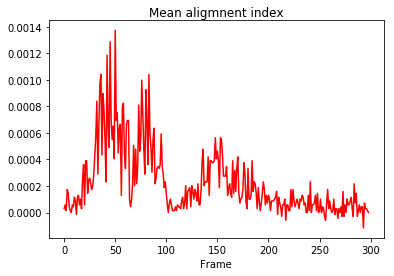

In [20]:
align_arr, speeds_arr = array_alignment_processor(arr, arr.shape[0], cv2_params)
print("arr shape: %s, align_arr shape: %s" % (arr.shape, align_arr.shape))
mean_align, mean_speed = np.nanmean(align_arr, axis=(1,2)), np.nanmean(speeds_arr, axis=(1,2))
plt.plot(mean_align, 'r')
plt.xlabel("Frame")
plt.title("Mean aligmnent index")
plt.show()


Alignment index looks surprisingly low, let's compare the openCV optic flow with openPIV, to see if the alignment indexes match up like the speeds.

In [21]:
def openPIV_array_processor(arr, stopFrame, startFrame=0, frameSamplingInterval=1, **piv_params):

    assert (startFrame < stopFrame) and (stopFrame <= arr.shape[0])
    
    n_frames = 1 + (stopFrame-startFrame-1) // frameSamplingInterval
    
    x, y = openpiv.process.get_coordinates(image_size=arr[0].shape,
                                           window_size=piv_params["window_size"],
                                           overlap=piv_params["overlap"])

    out_u = np.zeros((n_frames, x.shape[0], x.shape[1]))
    out_v = np.zeros_like(out_u)
    
    for frame in range(startFrame, stopFrame, frameSamplingInterval):

        if frame >= (stopFrame-1):
            break

        frame_a = arr[frame]
        frame_b = arr[frame+1]
             
        out_u[frame], out_v[frame], sig2noise = openpiv.process.extended_search_area_piv(frame_a, frame_b,
                                                                window_size=piv_params["window_size"],
                                                                overlap=piv_params["overlap"],
                                                                dt=piv_params["dt"],
                                                                search_area_size=piv_params["search_area_size"],
                                                                sig2noise_method=piv_params["sig2noise_method"])
    
    return out_u, out_v, x, y


In [52]:
t0 = time.time()

#PIV parameters
piv_params = dict(window_size = 32,
                overlap = 0,
                dt = 1,
                search_area_size = 36,
                sig2noise_method = "peak2peak")

print(piv_params)

openPIV_u, openPIV_v, openPIV_x, openPIV_y = openPIV_array_processor(arr, arr.shape[0], **piv_params)

print("Array processed in %.2f s" % (time.time()-t0))


{'dt': 1, 'window_size': 32, 'search_area_size': 36, 'sig2noise_method': 'peak2peak', 'overlap': 0}
Array processed in 20.45 s


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: Mean of empty slice


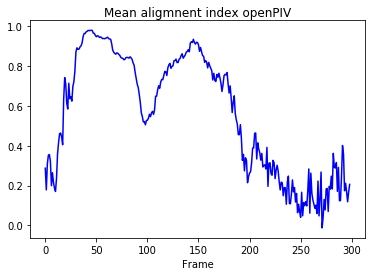

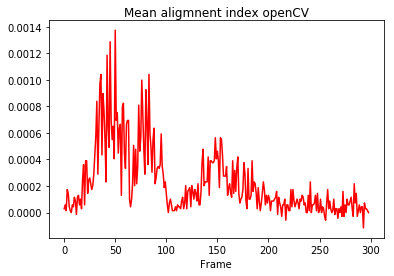

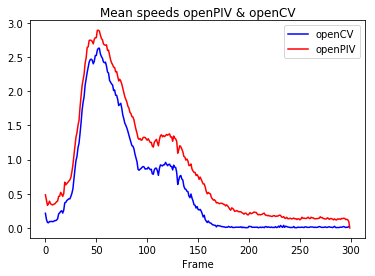

In [53]:
openPIV_mean_align, openPIV_speeds = [] , []
for frame in range(openPIV_u.shape[0]):
    al, sp = alignment_index(openPIV_u[frame], openPIV_v[frame])
    
    openPIV_mean_align.append(np.nanmean(al))
    openPIV_speeds.append(np.nanmean(sp))

plt.plot(openPIV_mean_align, 'b')
plt.xlabel("Frame")
plt.title("Mean aligmnent index openPIV")
plt.show()

plt.plot(mean_align, 'r')
plt.xlabel("Frame")
plt.title("Mean aligmnent index openCV")
plt.show()

plt.plot(mean_speed, 'b', label = "openCV")
plt.plot(openPIV_speeds, 'r', label="openPIV")
plt.xlabel("Frame")
plt.title("Mean speeds openPIV & openCV")
plt.legend()
plt.show()

Comparing speeds and aligmnent indexes between the algorithms reveal striking differences in the aligment index, but not in speeds. Let's explore the parameters for the polynomial expansion algorithm from openCV.

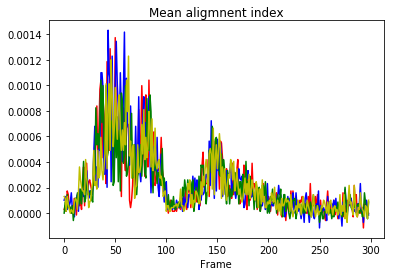

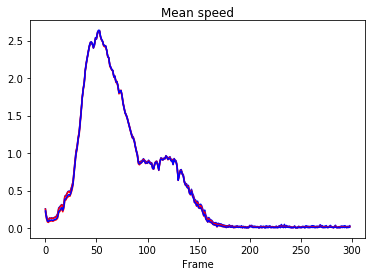

In [428]:
cv2_params1 = dict(flow = None,
              pyr_scale = 0.5,
                 levels = 3,
                winsize = 9,
             iterations = 3,
                 poly_n = 7,
             poly_sigma = 1.5,
                  flags = 0)

cv2_params2 = dict(flow = None,
              pyr_scale = 0.5,
                 levels = 1,
                winsize = 5,
             iterations = 1,
                 poly_n = 7,
             poly_sigma = 1.5,
                  flags = 0)

cv2_params3 = dict(flow = None,
              pyr_scale = 0.5,
                 levels = 1,
                winsize = 5,
             iterations = 1,
                 poly_n = 5,
             poly_sigma = 1.1,
                  flags = 0)

cv2_params4 = dict(flow = None,
              pyr_scale = 0.5,
                 levels = 1,
                winsize = 7,
             iterations = 1,
                 poly_n = 5,
             poly_sigma = 1.1,
                  flags = 0)

align_arr1, speeds_arr1 = array_alignment_processor(arr, arr.shape[0], **cv2_params1)
align_arr2, speeds_arr2 = array_alignment_processor(arr, arr.shape[0], **cv2_params2)
align_arr3, speeds_arr3 = array_alignment_processor(arr, arr.shape[0], **cv2_params3)
align_arr4, speeds_arr4 = array_alignment_processor(arr, arr.shape[0], **cv2_params4)

mean_align1, mean_speed1 = np.nanmean(align_arr1, axis=(1,2)), np.nanmean(speeds_arr1, axis=(1,2))
mean_align2, mean_speed2 = np.nanmean(align_arr2, axis=(1,2)), np.nanmean(speeds_arr2, axis=(1,2))
mean_align3, mean_speed3 = np.nanmean(align_arr3, axis=(1,2)), np.nanmean(speeds_arr3, axis=(1,2))
mean_align4, mean_speed4 = np.nanmean(align_arr4, axis=(1,2)), np.nanmean(speeds_arr4, axis=(1,2))



plt.plot(mean_align1, 'r', label = "params 1")
plt.plot(mean_align2, 'b', label = "params 2")
plt.plot(mean_align3, 'g', label = "params 3")
plt.plot(mean_align4, 'y', label = "params 4")
plt.xlabel("Frame")
plt.title("Mean aligmnent index")
plt.show()

plt.plot(mean_speed1, 'r', label = "params 1")
plt.plot(mean_speed2, 'b', label = "params 2")
plt.plot(mean_speed3, 'r', label = "params 3")
plt.plot(mean_speed4, 'b', label = "params 4")
plt.xlabel("Frame")
plt.title("Mean speed")
plt.show()




Ok, we have now seen that the Farenbäck implementationis wothless for alignment index and presumably for vectoral velocity correlation. Let's focus on implementing the rest off the equations: Mean square velocity (msv, $\langle|\textbf{v}(t)|^2\rangle$ ), Root mean square velocity ($\nu_{r.m.s}$), the instantaneous order parameter ($\psi$), and finally the vectorial velocity correlation function ($C_{VV}(r)$)

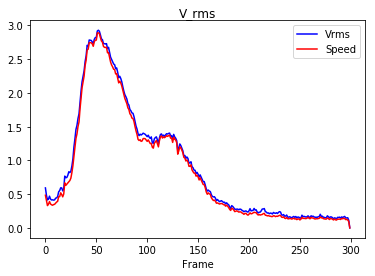

In [54]:
def msv(u, v): #Mean Square Velocity
    msv = np.mean(np.square(u)+np.square(v))
    return msv

def rms(u, v): #Root Mean Square Velocity
    rms = np.sqrt(np.mean(np.square(u)+np.square(v)))
    return rms

openPIV_Vrms, openPIV_speed = [], []

for frame in range(openPIV_u.shape[0]):
    Vrms = rms(openPIV_u[frame], openPIV_v[frame])
    openPIV_Vrms.append(Vrms)
    
    speed = np.mean(np.sqrt(np.square(openPIV_u[frame]) + np.square(openPIV_v[frame])))
    openPIV_speed.append(speed)
    
plt.plot(openPIV_Vrms, 'b', label = "Vrms")
plt.plot(openPIV_speed, 'r', label = "Speed")
plt.xlabel("Frame")
plt.title("V_rms")
plt.legend()
plt.show()

In [55]:
def smvvm(u, v): #square_mean_vectorial_velocity_magnitude

    return np.square(np.mean(u)) + np.square(np.mean(v))

def instantaneous_order_parameter(u, v):
    
    return smvvm(u, v)/msv(u, v)



/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars


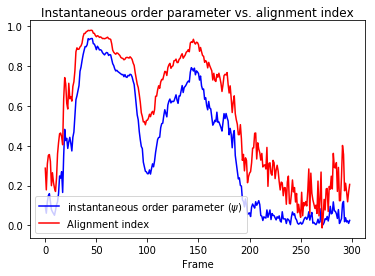

In [56]:
openPIV_iop = []

for frame in range(openPIV_u.shape[0]):
    iop = instantaneous_order_parameter(openPIV_u[frame], openPIV_v[frame])
    openPIV_iop.append(iop)
    
plt.plot(openPIV_iop, 'b', label = "instantaneous order parameter ($\psi$)")
plt.plot(openPIV_mean_align, 'r', label = "Alignment index")
plt.xlabel("Frame")
plt.title("Instantaneous order parameter vs. alignment index")
plt.legend()
plt.show()

In [474]:
t0 = time.time()

#PIV parameters
piv_params = dict(window_size = 32,
                overlap = 0,
                dt = 1,
                search_area_size = 36,
                sig2noise_method = "peak2peak")

print(piv_params)

openPIV_u, openPIV_v, openPIV_x, openPIV_y = openPIV_array_processor(arr, arr.shape[0], **piv_params)
openPIV_u2, openPIV_v2, openPIV_x2, openPIV_y2 = openPIV_array_processor(arr2, arr2.shape[0], **piv_params)

print("Arrays processed in %.2f s" % (time.time()-t0))




{'dt': 1, 'window_size': 32, 'search_area_size': 36, 'sig2noise_method': 'peak2peak', 'overlap': 0}
Arrays processed in 109.79 s


Let's revisit the openCV algo, but this time look at the order parameter instead of the alignment index.

In [475]:
t0 = time.time()

cv2_params = dict(flow = None,
              pyr_scale = 0.5,
                 levels = 3,
                winsize = 9,
             iterations = 3,
                 poly_n = 7,
             poly_sigma = 1.5,
                  flags = 0)

cv2_u, cv2_v = cv2_array_processor(arr, cv2_params, arr.shape[0])
cv2_u2, cv2_v2 = cv2_array_processor(arr2, cv2_params, arr2.shape[0])

print("Arrays processed in %.2f s" % (time.time()-t0))

Arrays processed in 43.72 s


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: Mean of empty slice


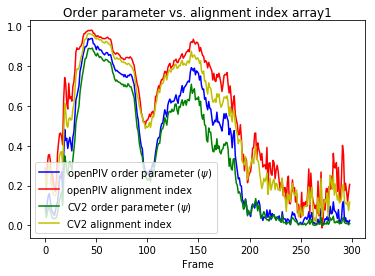

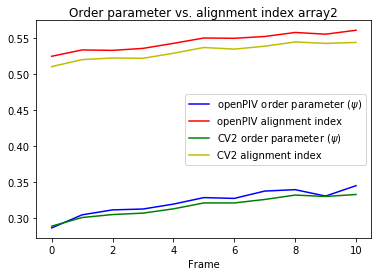

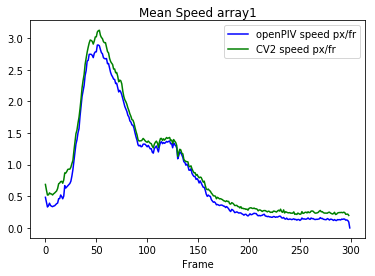

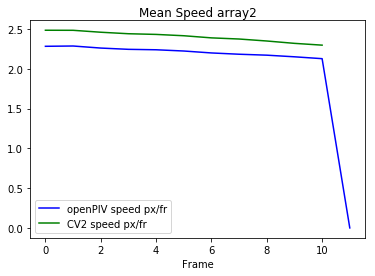

In [478]:
openPIV_iop, openPIV_ai, openPIV_speed  = [], [], []
for frame in range(openPIV_u.shape[0]):
    iop = instantaneous_order_parameter(openPIV_u[frame], openPIV_v[frame])
    openPIV_iop.append(iop)
    ai = alignment_index(openPIV_u[frame], openPIV_v[frame])
    openPIV_ai.append(np.nanmean(ai[0]))
    openPIV_speed.append(np.nanmean(ai[1]))

openPIV_iop2, openPIV_ai2, openPIV_speed2 = [], [], []
for frame in range(openPIV_u2.shape[0]):
    iop = instantaneous_order_parameter(openPIV_u2[frame], openPIV_v2[frame])
    openPIV_iop2.append(iop)
    ai = alignment_index(openPIV_u2[frame], openPIV_v2[frame])
    openPIV_ai2.append(np.nanmean(ai[0]))
    openPIV_speed2.append(np.nanmean(ai[1]))
    

cv2_ai, cv2_iop, cv2_speed = [], [], []
for frame in range(cv2_u.shape[0]):
    iop = instantaneous_order_parameter(cv2_u[frame], cv2_v[frame])
    cv2_iop.append(iop)
    ai = alignment_index(cv2_u[frame], cv2_v[frame])
    cv2_ai.append(np.nanmean(ai[0]))
    cv2_speed.append(np.nanmean(ai[1]))
       
cv2_ai2, cv2_iop2, cv2_speed2 = [], [], []
for frame in range(cv2_u2.shape[0]):
    iop = instantaneous_order_parameter(cv2_u2[frame], cv2_v2[frame])
    cv2_iop2.append(iop)
    ai = alignment_index(cv2_u2[frame], cv2_v2[frame])
    cv2_ai2.append(np.nanmean(ai[0]))
    cv2_speed2.append(np.nanmean(ai[1]))

plt.plot(openPIV_iop, 'b', label = "openPIV order parameter ($\psi$)")
plt.plot(openPIV_ai, 'r', label = "openPIV alignment index")
plt.plot(cv2_iop, 'g', label = "CV2 order parameter ($\psi$)")
plt.plot(cv2_ai, 'y', label = "CV2 alignment index")
plt.xlabel("Frame")
plt.title("Order parameter vs. alignment index array1")
plt.legend()
plt.show()
    
plt.plot(openPIV_iop2, 'b', label = "openPIV order parameter ($\psi$)")
plt.plot(openPIV_ai2, 'r', label = "openPIV alignment index")
plt.plot(cv2_iop2, 'g', label = "CV2 order parameter ($\psi$)")
plt.plot(cv2_ai2, 'y', label = "CV2 alignment index")
plt.xlabel("Frame")
plt.title("Order parameter vs. alignment index array2")
plt.legend()
plt.show()

plt.plot(openPIV_speed, 'b', label = "openPIV speed px/fr")
plt.plot(cv2_speed, 'g', label = "CV2 speed px/fr")
plt.xlabel("Frame")
plt.title("Mean Speed array1")
plt.legend()
plt.show()

plt.plot(openPIV_speed2, 'b', label = "openPIV speed px/fr")
plt.plot(cv2_speed2, 'g', label = "CV2 speed px/fr")
plt.xlabel("Frame")
plt.title("Mean Speed array2")
plt.legend()
plt.show()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars


Array processed in 175.71 s
(654, 512, 512)
(654, 16, 16)


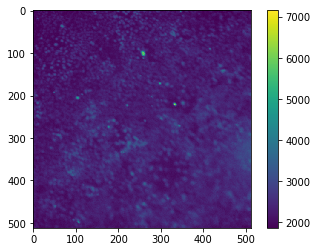

In [33]:
t0 = time.time()

testfile3 = "/Users/jens_e/Python_laboratory/Vector_visualizer/PNAS paper movies/Single RAW subframes/160124_HaCaT_H2B_Starve_serum_0px_3ml_T0_52min_1_MMStack_1-Pos_003_003.ome.tif"
with tiffile.TiffFile(testfile3) as tif:
    arr3 = tif.asarray()
    arr3 = arr3.astype(np.int32)

#PIV parameters
piv_params = dict(window_size = 32,
                overlap = 0,
                dt = 1,
                search_area_size = 36,
                sig2noise_method = "peak2peak")


openPIV_u3, openPIV_v3, openPIV_x3, openPIV_y3 = openPIV_array_processor(arr3, arr3.shape[0], **piv_params)

openPIV_iop3, openPIV_ai3, openPIV_speed3  = [], [], []
for frame in range(openPIV_u3.shape[0]):
    iop = instantaneous_order_parameter(openPIV_u3[frame], openPIV_v3[frame])
    openPIV_iop3.append(iop)
    ai = alignment_index(openPIV_u3[frame], openPIV_v3[frame])
    openPIV_ai3.append(np.nanmean(ai[0]))
    openPIV_speed3.append(np.nanmean(ai[1]))
    
print("Array processed in %.2f s" % (time.time()-t0))

print(arr3.shape)
print(openPIV_u3.shape)

show_animation(arr3)

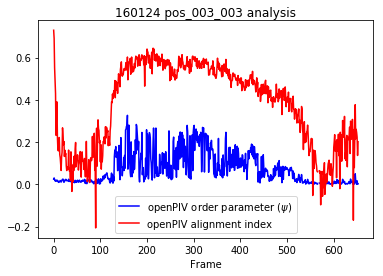

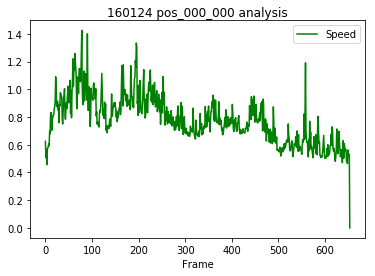

In [34]:
plt.plot(openPIV_iop3, 'b', label = "openPIV order parameter ($\psi$)")
plt.plot(openPIV_ai3, 'r', label = "openPIV alignment index")
plt.xlabel("Frame")
plt.title("160124 pos_003_003 analysis")
plt.legend()
plt.show()

plt.plot(openPIV_speed3, 'g', label = "Speed")
plt.xlabel("Frame")
plt.title("160124 pos_003_003 analysis")
plt.legend()
plt.show()


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: Mean of empty slice


Array processed in 161.06 s
(713, 512, 512)
(713, 16, 16)


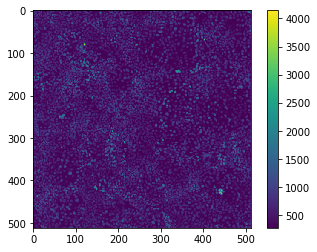

In [37]:
t0 = time.time()

testfile3 = "/Users/jens_e/Python_laboratory/Vector_visualizer/PNAS paper movies/Single RAW subframes/160126_H2B_T0_1h_3ml_serum_1_MMStack_2-Pos_004_004.ome.tif"
with tiffile.TiffFile(testfile3) as tif:
    arr3 = tif.asarray()
    arr3 = arr3.astype(np.int32)

#PIV parameters
piv_params = dict(window_size = 32,
                overlap = 0,
                dt = 1,
                search_area_size = 36,
                sig2noise_method = "peak2peak")


openPIV_u3, openPIV_v3, openPIV_x3, openPIV_y3 = openPIV_array_processor(arr3, arr3.shape[0], **piv_params)

openPIV_iop3, openPIV_ai3, openPIV_speed3  = [], [], []
for frame in range(openPIV_u3.shape[0]):
    iop = instantaneous_order_parameter(openPIV_u3[frame], openPIV_v3[frame])
    openPIV_iop3.append(iop)
    ai = alignment_index(openPIV_u3[frame], openPIV_v3[frame])
    openPIV_ai3.append(np.nanmean(ai[0]))
    openPIV_speed3.append(np.nanmean(ai[1]))
    

print("Array processed in %.2f s" % (time.time()-t0))

print(arr3.shape)
print(openPIV_u3.shape)
show_animation(arr3)

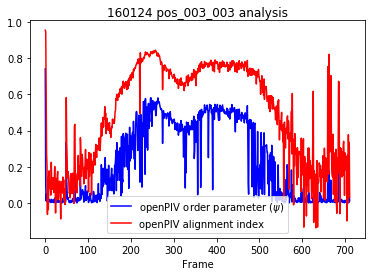

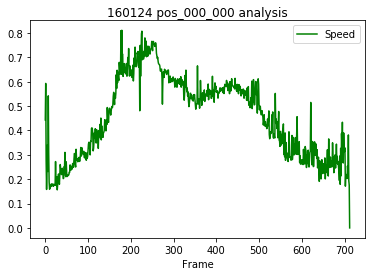

In [38]:
plt.plot(openPIV_iop3, 'b', label = "openPIV order parameter ($\psi$)")
plt.plot(openPIV_ai3, 'r', label = "openPIV alignment index")
plt.xlabel("Frame")
plt.title("160126 pos_004_004 analysis")
plt.legend()
plt.show()

plt.plot(openPIV_speed3, 'g', label = "Speed")
plt.xlabel("Frame")
plt.title("160126 pos_004_004 analysis")
plt.legend()
plt.show()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: Mean of empty slice


Array processed in 308.81 s
(976, 512, 512)
(976, 16, 16)


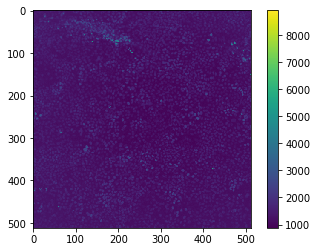

In [39]:
t0 = time.time()

testfile3 = "/Users/jens_e/Python_laboratory/Vector_visualizer/PNAS paper movies/Single RAW subframes/160205_H2B_3ml_T0_35min_1_MMStack_3-Pos_004_004.ome.tif"
with tiffile.TiffFile(testfile3) as tif:
    arr3 = tif.asarray()
    arr3 = arr3.astype(np.int32)

#PIV parameters
piv_params = dict(window_size = 32,
                overlap = 0,
                dt = 1,
                search_area_size = 36,
                sig2noise_method = "peak2peak")


openPIV_u3, openPIV_v3, openPIV_x3, openPIV_y3 = openPIV_array_processor(arr3, arr3.shape[0], **piv_params)

openPIV_iop3, openPIV_ai3, openPIV_speed3  = [], [], []
for frame in range(openPIV_u3.shape[0]):
    iop = instantaneous_order_parameter(openPIV_u3[frame], openPIV_v3[frame])
    openPIV_iop3.append(iop)
    ai = alignment_index(openPIV_u3[frame], openPIV_v3[frame])
    openPIV_ai3.append(np.nanmean(ai[0]))
    openPIV_speed3.append(np.nanmean(ai[1]))
    

print("Array processed in %.2f s" % (time.time()-t0))

print(arr3.shape)
print(openPIV_u3.shape)
show_animation(arr3)

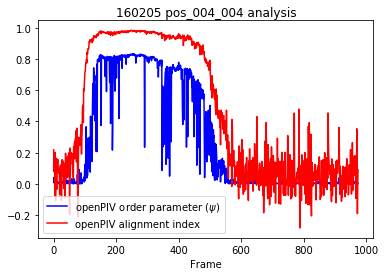

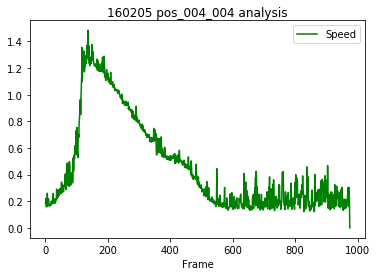

In [40]:
plt.plot(openPIV_iop3, 'b', label = "openPIV order parameter ($\psi$)")
plt.plot(openPIV_ai3, 'r', label = "openPIV alignment index")
plt.xlabel("Frame")
plt.title("160205 pos_004_004 analysis")
plt.legend()
plt.show()

plt.plot(openPIV_speed3, 'g', label = "Speed")
plt.xlabel("Frame")
plt.title("160205 pos_004_004 analysis")
plt.legend()
plt.show()

Now we are cooking with fire, let's see if we can apply a temporal median filter to the raw data while we process.

In [73]:
def openPIV_array_processor_median(arr, stopFrame, startFrame=0, frameSamplingInterval=1, **piv_params):

    assert (startFrame < stopFrame) and (stopFrame <= arr.shape[0])
    
    n_frames = 1 + (stopFrame-startFrame-4) // frameSamplingInterval
    
    x, y = openpiv.process.get_coordinates(image_size=arr[0].shape,
                                           window_size=piv_params["window_size"],
                                           overlap=piv_params["overlap"])

    out_u = np.zeros((n_frames, x.shape[0], x.shape[1]))
    out_v = np.zeros_like(out_u)
    
    for frame in range(startFrame, stopFrame, frameSamplingInterval):

        if frame >= (stopFrame-4):
            break

        frame_a = np.median(arr[frame:frame+3], axis=0).astype(np.int32)
        frame_b = np.median(arr[frame+1:frame+4], axis=0).astype(np.int32)
             
        out_u[frame], out_v[frame], sig2noise = openpiv.process.extended_search_area_piv(frame_a, frame_b,
                                                                window_size=piv_params["window_size"],
                                                                overlap=piv_params["overlap"],
                                                                dt=piv_params["dt"],
                                                                search_area_size=piv_params["search_area_size"],
                                                                sig2noise_method=piv_params["sig2noise_method"])
    return out_u, out_v, x, y



/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: Mean of empty slice


Array processed in 1295.77 s
(976, 512, 512)
(973, 31, 31)


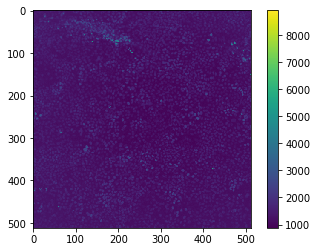

In [50]:
t0 = time.time()

testfile3 = "/Users/jens_e/Python_laboratory/Vector_visualizer/PNAS paper movies/Single RAW subframes/160205_H2B_3ml_T0_35min_1_MMStack_3-Pos_004_004.ome.tif"
with tiffile.TiffFile(testfile3) as tif:
    arr3 = tif.asarray()
    arr3 = arr3.astype(np.int32)

#PIV parameters
piv_params = dict(window_size = 32,
                overlap = 16,
                dt = 1,
                search_area_size = 36,
                sig2noise_method = "peak2peak")


openPIV_u3, openPIV_v3, openPIV_x3, openPIV_y3 = openPIV_array_processor_median(arr3, arr3.shape[0], **piv_params)

openPIV_iop3, openPIV_ai3, openPIV_speed3  = [], [], []
for frame in range(openPIV_u3.shape[0]):
    iop = instantaneous_order_parameter(openPIV_u3[frame], openPIV_v3[frame])
    openPIV_iop3.append(iop)
    ai = alignment_index(openPIV_u3[frame], openPIV_v3[frame])
    openPIV_ai3.append(np.nanmean(ai[0]))
    openPIV_speed3.append(np.nanmean(ai[1]))
    

print("Array processed in %.2f s" % (time.time()-t0))

print(arr3.shape)
print(openPIV_u3.shape)
show_animation(arr3)

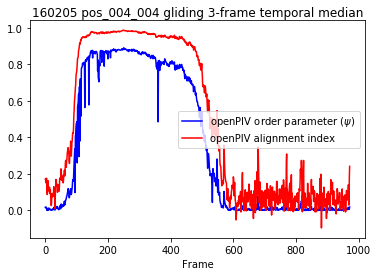

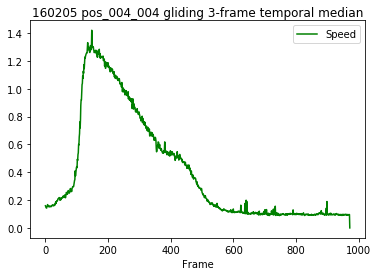

In [51]:
plt.plot(openPIV_iop3, 'b', label = "openPIV order parameter ($\psi$)")
plt.plot(openPIV_ai3, 'r', label = "openPIV alignment index")
plt.xlabel("Frame")
plt.title("160205 pos_004_004 gliding 3-frame temporal median")
plt.legend()
plt.show()

plt.plot(openPIV_speed3, 'g', label = "Speed")
plt.xlabel("Frame")
plt.title("160205 pos_004_004 gliding 3-frame temporal median")
plt.legend()
plt.show()

Now I'll have to devise a way to get the vectorial velocity correlation function ($C_{VV}(r)$, the distance-dependent Velocity (Speed & Direction) correlation). My idea is to randomly select n≈100 regions per hour and do manual $C_{VV}(r)$ on them.

1a: Select N random PIV vectors as $V_{0}$.

1b: Select the N vectors along the diagonal of the PIV array as $V_{0}$

2a: Get vectors within r = ($r_{min}, r_{min}+r_{increment}, ... ,r_{max}-r_{increment}, r_{max}$) µm of V0 and make sure not to include edges or "out of bounds" vector positions.

2b: Get only the vectors n*r from $V_{0}$ by exanding lineraly straight up/down & left/right from $V_{0}$.

3: Compute the average velocity correlation for r, which is the mean of the dot products of $V_{0}$ and $V_{r}$. $C_{VV}(r) = \frac{1}{N} * \sum\limits_{i=1}^N <V_{0} \cdotp V_{r}>$, where N is the number of samples and $<V_{0} \cdotp V_{r}>$ is the mean of the dot products of $V_{0}$ and the vectors a distance of r from $V_{0}$ in the four cardinal directions.



In [94]:
def get_v0_plus_r_coordinates_cardinal(array_shape, v0_cord, r):

    """
    Gets the 4 coordinates of the pixels r away from the coordinate (v0_x, v0_y) in the four cardinal directions.
    The coordinates are returned in Matrix/numpy form (row,col), i.e. (y,x) when compared to traditional image
    coordinate numbering.

    :param array_shape: (tuple)
    :param v0_cord: (tuple) of (ints), (row, col) coordinates of v0 in matrix notation.
    :param r: (int) distance from v0 along the cardinal directions
    :return: List of coordinates in martix notation, if no valid coordinates are found an empty list is returned.

    """

    array_width = array_shape[1]
    array_height = array_shape[0]
    v0_r = v0_cord[0]
    v0_c = v0_cord[1]

    assert r>0, "r needs to be positive and >0 !"
    assert array_width > v0_c, "v0_y needs to be less than array_width!"
    assert v0_c >= 0 , "v0_y needs to be positive!"
    assert array_height > v0_r, "v0_y needs to be < array_height!"
    assert v0_r >= 0, "v0_y needs to be positive and < array_height!"

    top_r = v0_r-r
    right_c = v0_c+r
    bottom_r = v0_r+r
    left_c = v0_c-r

    out = []


    if (top_r >= 0):
        out.append((top_r, v0_c))

    if (right_c < array_width):
        out.append((v0_r, right_c))

    if (bottom_r < array_height):
        out.append((bottom_r, v0_c))

    if (left_c >= 0):
        out.append((v0_r, left_c))

    return out



In [84]:
#PIV parameters
piv_params = dict(window_size = 32,
                overlap = 16,
                dt = 1,
                search_area_size = 36,
                sig2noise_method = "peak2peak")


openPIV_u, openPIV_v, openPIV_x, openPIV_y = openPIV_array_processor_median(arr, arr.shape[0], **piv_params)

print(arr.shape, openPIV_u.shape)

(300, 263, 263) (297, 15, 15)


In [226]:
def get_velocity_correlations(u_array, v_array, v0_coord, resultsDict, r_max, r_step=1, r_min=1):
    
    assert u_array.shape == v_array.shape, "u and v component arrays have to have identical shapes"
    
    v0 = (u_array[v0_coord], v_array[v0_coord])
    
    dot_products = u_array*v0[0] + v_array*v0[1] #Computes ALL the dot products with v0
    
    
    for r in range(r_min, r_max, r_step):
        
        coords = get_v0_plus_r_coordinates_cardinal(u_array.shape, v0_coord, r)

        if len(coords) == 0:
            break
        for c in coords:
            
            resultsDict[r] = [resultsDict.get(r, [0,0,0])[0] + dot_products[c],
                              resultsDict.get(r, [0,0,0])[1] + 1, 0
                             ]
    for k in resultsDict:
        resultsDict[k][2] = resultsDict[k][0]/resultsDict[k][1]

    return resultsDict

def get_normalized_velocity_correlations(u_array, v_array, v0_coord, resultsDict, r_max, r_step=1, r_min=1):
    
    assert u_array.shape == v_array.shape, "u and v component arrays have to have identical shapes"
    
    v0_u = u_array[v0_coord]
    v0_v = v_array[v0_coord]
    
    v0 = (v0_u, v0_v)
    
    v0_square_norm = (v0_u**2 + v0_v**2) 
    
    if (v0_square_norm == 0):
        return resultsDict
        
    
    dot_products = u_array*v0[0] + v_array*v0[1] #Computes ALL the dot products with v0
    
    dot_products /= float(v0_square_norm)
        
    for r in range(r_min, r_max, r_step):
        
        coords = get_v0_plus_r_coordinates_cardinal(u_array.shape, v0_coord, r)

        if len(coords) == 0:
            break
        for c in coords:
            
            resultsDict[r] = [resultsDict.get(r, [0,0,0])[0] + dot_products[c], #if r not in dict return the list [0,0,0]
                              resultsDict.get(r, [0,0,0])[1] + 1, 0
                             ]
    for k in resultsDict:
        resultsDict[k][2] = resultsDict[k][0]/resultsDict[k][1]

    return resultsDict
     

(297, 15, 15)


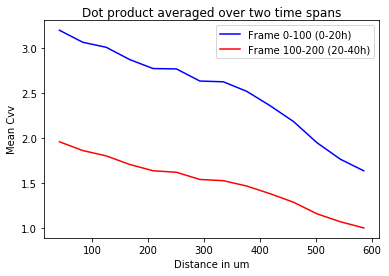

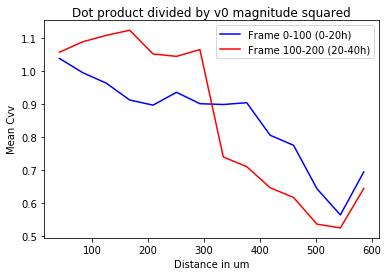

In [246]:

tmp = openPIV_u.copy()
print(tmp.shape)
results={}

for t in range(0,100):    
    for d in range(0, min(tmp.shape[1], tmp.shape[2])):
        results = get_velocity_correlations(openPIV_u[t], openPIV_v[t], (d,d), results, 30, 1)
        
x, y = [], []
for k, v in results.items():
    x.append(k*41.8624)
    y.append(v[2])

plt.plot(x, y, 'b', label = "Frame 0-100 (0-20h)")

for t in range(100,200):    
    for d in range(0, min(tmp.shape[1], tmp.shape[2])):
        results = get_velocity_correlations(openPIV_u[t], openPIV_v[t], (d,d), results, 30, 1)

x, y = [], []
for k, v in results.items():
    x.append(k*41.8624)
    y.append(v[2])

plt.plot(x, y, 'r', label = "Frame 100-200 (20-40h)")
plt.legend()
plt.title("Dot product averaged over two time spans")
plt.xlabel("Distance in um")
plt.ylabel("Mean Cvv")
plt.show()

results={}
for t in range(0,100):    
    for d in range(0, min(tmp.shape[1], tmp.shape[2])):
        results = get_normalized_velocity_correlations(openPIV_u[t], openPIV_v[t], (d,d), results, 30, 1)
        
x, y = [], []
for k, v in results.items():
    x.append(k*41.8624)
    y.append(v[2])

plt.plot(x, y, 'b', label = "Frame 0-100 (0-20h)")

for t in range(100,200):    
    for d in range(0, min(tmp.shape[1], tmp.shape[2])):
        results = get_normalized_velocity_correlations(openPIV_u[t], openPIV_v[t], (d,d), results, 30, 1)

x, y = [], []
for k, v in results.items():
    x.append(k*41.8624)
    y.append(v[2])

plt.plot(x, y, 'r', label = "Frame 100-200 (20-40h)")
plt.legend()
plt.title("Dot product divided by v0 magnitude squared")
plt.xlabel("Distance in um")
plt.ylabel("Mean Cvv")
plt.show()

In [161]:

openPIV_u2, openPIV_v2, openPIV_x2, openPIV_y2 = openPIV_array_processor_median(arr2, arr2.shape[0], **piv_params)

print(arr2.shape, openPIV_u2.shape)

(300, 263, 263) (297, 15, 15)


(9, 157, 157)


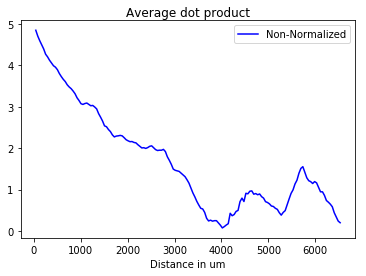

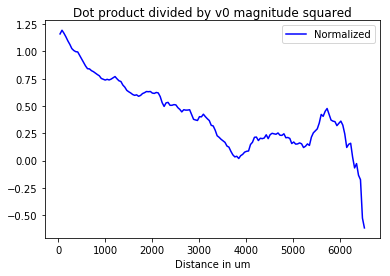

In [247]:
tmp = openPIV_u2.copy()
print(tmp.shape)
results={}
for t in range(tmp.shape[0]):    
    for d in range(min(tmp.shape[1], tmp.shape[2])):
        results = get_velocity_correlations(openPIV_u2[t], openPIV_v2[t], (d,d), results, 300, 1)

x, y, N = [], [], []
for k, v in results.items():
    x.append(k*41.8624)
    y.append(v[2])
    N.append(v[1])

plt.plot(x, y, 'b', label = "Non-Normalized")
plt.legend()
plt.title("Average dot product")
plt.xlabel("Distance in um")
plt.show()

results={}
for t in range(tmp.shape[0]):    
    for d in range(min(tmp.shape[1], tmp.shape[2])):
        results = get_normalized_velocity_correlations(openPIV_u2[t], openPIV_v2[t], (d,d), results, 300, 1)

x, y, N = [], [], []
for k, v in results.items():
    x.append(k*41.8624)
    y.append(v[2])
    N.append(v[1])

plt.plot(x, y, 'b', label = "Normalized")
plt.legend()
plt.title("Dot product divided by v0 magnitude squared")
plt.xlabel("Distance in um")
plt.show()

In [189]:
with tiffile.TiffFile("/Users/jens_e/Python_laboratory/Vector_visualizer/test/med_raw_masked.tif") as tif:
    arr2_mask = tif.asarray()
    arr2_mask = arr2_mask.astype(np.int32)

openPIV_u2_mask, openPIV_v2_mask, openPIV_x2, openPIV_y2 = openPIV_array_processor_median(arr2_mask, arr2_mask.shape[0], **piv_params)

print(arr2_mask.shape, openPIV_u2_mask.shape)

(12, 2542, 2542) (9, 157, 157)


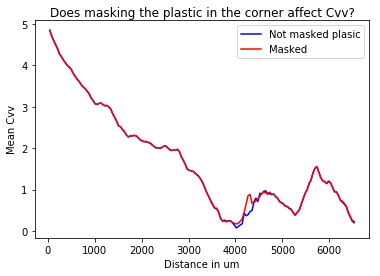

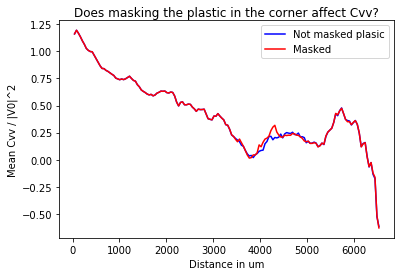

In [251]:
tmp = openPIV_u2.copy()

results={}
results_mask={}

for t in range(tmp.shape[0]):
    for d in range(0, min(tmp.shape[1], tmp.shape[2])):
        results = get_velocity_correlations(openPIV_u2[t], openPIV_v2[t], (d,d), results, 300, 1)
        results_mask = get_velocity_correlations(openPIV_u2_mask[t], openPIV_v2_mask[t], (d,d), results_mask, 300, 1)

x = []
y = []

x_mask = []
y_mask = []
for k, v in results.items():
    x.append(k*41.8624)
    y.append(v[2])

for k, v in results_mask.items():
    x_mask.append(k*41.8624)
    y_mask.append(v[2])

    
    
plt.plot(x, y, 'b', label = "Not masked plasic")
plt.plot(x_mask, y_mask, 'r', label = "Masked")
plt.legend()
plt.title("Does masking the plastic in the corner affect Cvv?")
plt.xlabel("Distance in um")
plt.ylabel("Mean Cvv")
plt.show()

results={}
results_mask={}

for t in range(tmp.shape[0]):
    for d in range(0, min(tmp.shape[1], tmp.shape[2])):
        results = get_normalized_velocity_correlations(openPIV_u2[t], openPIV_v2[t], (d,d), results, 300, 1)
        results_mask = get_normalized_velocity_correlations(openPIV_u2_mask[t], openPIV_v2_mask[t], (d,d), results_mask, 300, 1)

x = []
y = []

x_mask = []
y_mask = []
for k, v in results.items():
    x.append(k*41.8624)
    y.append(v[2])

for k, v in results_mask.items():
    x_mask.append(k*41.8624)
    y_mask.append(v[2])

    
    
plt.plot(x, y, 'b', label = "Not masked plasic")
plt.plot(x_mask, y_mask, 'r', label = "Masked")
plt.legend()
plt.title("Does masking the plastic in the corner affect Cvv?")
plt.xlabel("Distance in um")
plt.ylabel("Mean Cvv / |V0|^2")
plt.show()




Dividing $ <v_{0} \cdot v_{r}> $ by the square magnitude of $v_{0}$, $|v_{0}|^2$, does not normalize $C_{vv} (r)$ to the range [-1, +1]. In statistical mechanics the equal-time (spatial) correlation function is defined like this:
$C (r) = \langle \mathbf{s_1}(0) \cdot \mathbf{s_2}(r)\rangle\ - \langle \mathbf{s_1}(0) \rangle\langle \mathbf{s_2}(r) \rangle\,.$

Let's see what happens when we subtract $|v_{0}|*|v_{r}|$ from $ v_{0} \cdot v_{r} $, like this: $C (r) = \langle \mathbf{v_0} \cdot \mathbf{v_r}\rangle\ - \langle \mathbf{|v_0|*|v_r|} \rangle$.

We can also try to divide by the term, like this:

$C_{vv}(r) = \frac{<v_{0} \cdot v_{r}>}{<|v_0|*|v_r|>} $, which is just the cosinus of the angle between the vectors.

$\mathbf{a}\cdot\mathbf{b}=\|\mathbf{a}\|\ \|\mathbf{b}\|\cos(\theta)$

$\cos(\theta) = C_{vv}(r) = \frac{<v_{0} \cdot v_{r}>}{<|v_0|*|v_r|>} $

In [266]:
def get_subtracting_velocity_correlations(u_array, v_array, v0_coord, resultsDict, r_max, r_step=1, r_min=1):
    
    assert u_array.shape == v_array.shape, "u and v component arrays have to have identical shapes"
    
    v0_u = u_array[v0_coord]
    v0_v = v_array[v0_coord]
    
    v0 = (v0_u, v0_v)
    
    
    
  
    magnitudes = np.sqrt(np.square(u_array) + np.square(v_array))
    v0_magnitude = magnitudes[v0_coord]
    
    dot_products = u_array*v0[0] + v_array*v0[1] #Computes ALL the dot products with v0
    magnitudes = magnitudes*v0_magnitude #Multiplies all magnitudes by the magnitude of v0
        
    for r in range(r_min, r_max, r_step):
        
        coords = get_v0_plus_r_coordinates_cardinal(u_array.shape, v0_coord, r)

        if len(coords) == 0:
            break
        for c in coords:
            c_vv = dot_products[c]-magnitudes[c]
            resultsDict[r] = [resultsDict.get(r, [0,0,0])[0] + c_vv, #if r not in dict return the list [0,0,0]
                              resultsDict.get(r, [0,0,0])[1] + 1, 0
                             ]
    for k in resultsDict:
        resultsDict[k][2] = resultsDict[k][0]/resultsDict[k][1]

    return resultsDict

def get_cos_angles_v0_vr(u_array, v_array, v0_coord, resultsDict, r_max, r_step=1, r_min=1):
    
    assert u_array.shape == v_array.shape, "u and v component arrays have to have identical shapes"
    
    v0_u = u_array[v0_coord]
    v0_v = v_array[v0_coord]
    
    magnitudes = np.sqrt(np.square(u_array) + np.square(v_array))
    v0_magnitude = magnitudes[v0_coord]
    
    dot_products = u_array*v0_u + v_array*v0_v #Computes ALL the dot products with v0
    magnitudes = magnitudes*v0_magnitude #Multiplies all magnitudes by the magnitude of v0
        
    for r in range(r_min, r_max, r_step):
        
        coords = get_v0_plus_r_coordinates_cardinal(u_array.shape, v0_coord, r)

        if len(coords) == 0:
            break
        for c in coords:
            if magnitudes[c] == 0:
                pass
            else:
                c_vv = dot_products[c]/magnitudes[c]
                resultsDict[r] = [resultsDict.get(r, [0,0,0])[0] + c_vv, #if r not in dict return the list [0,0,0]
                                  resultsDict.get(r, [0,0,0])[1] + 1, 0
                                 ]
    for k in resultsDict:
        resultsDict[k][2] = resultsDict[k][0]/resultsDict[k][1]

    return resultsDict

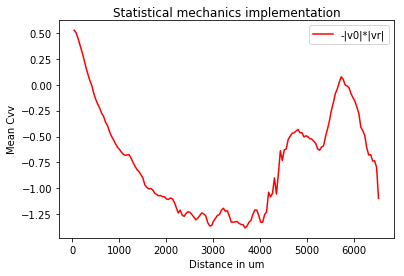

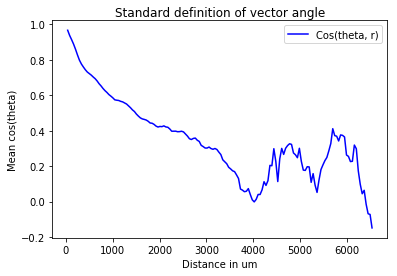

In [267]:
tmp = openPIV_u2.copy()

results={}
results_mask={}

for t in range(tmp.shape[0]):
    for d in range(0, min(tmp.shape[1], tmp.shape[2])):
        results = get_normalized_velocity_correlations(openPIV_u2[t], openPIV_v2[t], (d,d), results, 300, 1)
        results_mask = get_subtracting_velocity_correlations(openPIV_u2[t], openPIV_v2[t], (d,d), results, 300, 1)
x = []
y = []

x_mask = []
y_mask = []
for k, v in results.items():
    x.append(k*41.8624)
    y.append(v[2])

for k, v in results_mask.items():
    x_mask.append(k*41.8624)
    y_mask.append(v[2])

    
plt.plot(x_mask, y_mask, 'r', label = "-|v0|*|vr|")
plt.legend()
plt.title("Statistical mechanics implementation")
plt.xlabel("Distance in um")
plt.ylabel("Mean Cvv")
plt.show()


tmp = openPIV_u2.copy()

results={}
results_mask={}

for t in range(tmp.shape[0]):
    for d in range(0, min(tmp.shape[1], tmp.shape[2])):
        results_mask = get_cos_angles_v0_vr(openPIV_u2[t], openPIV_v2[t], (d,d), results, 300, 1)

x_mask = []
y_mask = []

for k, v in results_mask.items():
    x_mask.append(k*41.8624)
    y_mask.append(v[2])

    
    
#plt.plot(x, y, 'b', label = "V0 / |v0|^2")
plt.plot(x_mask, y_mask, 'b', label = "Cos(theta, r)")
plt.legend()
plt.title("Standard definition of vector angle")
plt.xlabel("Distance in um")
plt.ylabel("Mean cos(theta)")
plt.show()


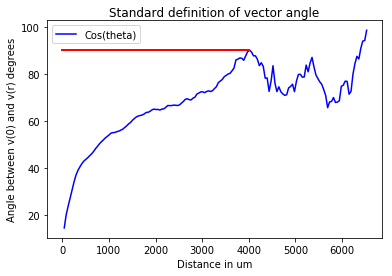

In [282]:
x_mask = []
y_mask = []

for k, v in results_mask.items():
    x_mask.append(k*41.8624)
    y_mask.append(math.acos(v[2])*(180/math.pi))

    
    
#plt.plot(x, y, 'b', label = "V0 / |v0|^2")
plt.plot(x_mask, y_mask, 'b', label = "Cos(theta)")
plt.plot([0,4000], [90, 90], 'r-', lw=2)
plt.legend()
plt.title("Standard definition of vector angle")
plt.xlabel("Distance in um")
plt.ylabel("Angle between v(0) and v(r) degrees")
plt.show()

I got it! Angular correlation length will be defined as the max distance where the cosinus of the angle between v(0) and v(r) remains >0 with a significance level of 3$\sigma$

In [338]:
def get_all_angles(u_array, v_array, v0_coord, resultsDict, r_max, r_step=1, r_min=1):
    
    assert u_array.shape == v_array.shape, "u and v component arrays have to have identical shapes"
    
    v0_u = u_array[v0_coord]
    v0_v = v_array[v0_coord]
    
    magnitudes = np.sqrt(np.square(u_array) + np.square(v_array))
    v0_magnitude = magnitudes[v0_coord]
    
    dot_products = u_array*v0_u + v_array*v0_v #Computes ALL the dot products with v0
    magnitudes = magnitudes*v0_magnitude #Multiplies all magnitudes by the magnitude of v0
        
    for r in range(r_min, r_max, r_step):
        if not r in resultsDict:
            resultsDict[r] = []
            
        
        coords = get_v0_plus_r_coordinates_cardinal(u_array.shape, v0_coord, r)

        if len(coords) == 0:
            break #stop when we run out of valid coordinates
        for c in coords:
            if magnitudes[c] == 0:
                pass
            else:
                c_vv = dot_products[c]/magnitudes[c]
                resultsDict[r].append(c_vv)
        
    
    for k, v in resultsDict.items():
        if len(resultsDict[k]) == 0:
            resultsDict.pop(r, None) #No need to save empty data lists, it breaks the statistics
            
    return resultsDict

3-sigma reached at r=91, last significant distance was 3767.62 um


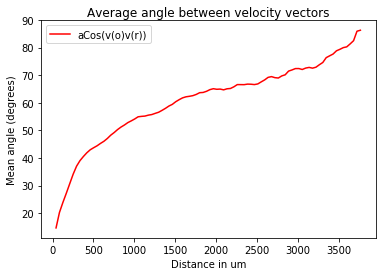

In [345]:
tmp = openPIV_u2.copy()

results={}

for t in range(tmp.shape[0]):
    for d in range(0, min(tmp.shape[1], tmp.shape[2])):
        results = get_all_angles(openPIV_u2[t], openPIV_v2[t], (d,d), results, 300, 1)
        
x = []
y = []

for k, v in results.items():
    
    if (len(v) == 0):
        print("Empty value at r=%i" % (k))
        break
    mean = np.nanmean(v)
    mean_deg = math.acos(mean)*(180/math.pi)
    sd = np.nanstd(v)
    sd_deg = math.acos(sd)*(180/math.pi)
    SEM = sd_deg/math.sqrt(len(v))
    #print(k, mean_deg, len(v), mean_deg+3*SEM)
    if (mean_deg+3*SEM > 90):
        print("3-sigma reached at r=%i, last significant distance was %.2f um" % (k, x[-1]))
        break
    x.append(k*41.8624)
    y.append(mean_deg)

    
plt.plot(x, y, 'r', label = "aCos(v(o)v(r))")
plt.legend()
plt.title("Average angle between velocity vectors")
plt.xlabel("Distance in um")
plt.ylabel("Mean angle (degrees)")
plt.show()
